# Deep End-to-end Causal Inference: Demo Notebook

This notebook provides a showcase of the features provided by our open source code for Deep End-to-end Causal Inference (DECI).

 - We begin with a simple two node example, showing how DECI can orient an edge correctly when non-Gaussian noise is present, and how DECI can then be used for treatment effect estimation
 - We show how different graph constraints can be incorporated into DECI
 - We showcase DECI on a larger graph example
 
### Dataset availability
To use the notebook, the CSuite datasets need to be available. Ensure that you have run the CSuite data generation script in `causica/data_generation/csuite/simulate.py` before attempting to load datasets.

For Microsoft internal users, the datasets will be automatically downloaded from storage.

In [1]:
import os
# Use this to set the notebook's working directory to the top-level directory, where ./data is located
os.chdir("../../..")

In [2]:
from open_source.causica.experiment.steps.step_func import load_data
from open_source.causica.models.deci.deci import DECI
import seaborn as sns
import pandas as pd
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt

import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

def plot_true_graph(dataset):
    true_graph = nx.convert_matrix.from_numpy_matrix(dataset.get_adjacency_data_matrix(), create_using=nx.DiGraph)
    nx.draw_networkx(true_graph, arrows=True, with_labels=True)

In [3]:
%matplotlib inline

In [4]:
dataset_config = {'dataset_format': 'causal_csv', 'use_predefined_dataset': True, 'test_fraction': 0.1, 
                  'val_fraction': 0.1, 'random_seed': 0, 'negative_sample': False}
model_config = {'tau_gumbel': 0.25, 'lambda_dag': 100.0, 'lambda_sparse': 5.0, 'spline_bins': 8, 
                'var_dist_A_mode': 'enco', 'mode_adjacency': 'learn', 
                'norm_layers': True, 'res_connection': True, 'base_distribution_type': 'spline'}
# To speed up training you can try:
#  increasing learning_rate
#  increasing batch_size (reduces noise when using higher learning rate)
#  decreasing max_steps_auglag (go as low as you can and still get a DAG)
#  decreasing max_auglag_inner_epochs
training_params = {'learning_rate': 0.05, 'batch_size': 256, 'stardardize_data_mean': False, 
                   'stardardize_data_std': False, 'rho': 1.0, 'safety_rho': 10000000000000.0, 
                   'alpha': 0.0, 'safety_alpha': 10000000000000.0, 'tol_dag': 1e-04, 'progress_rate': 0.65, 
                   'max_steps_auglag': 5, 'max_auglag_inner_epochs': 2000, 'max_p_train_dropout': 0.6, 
                   'reconstruction_loss_factor': 1.0, 'anneal_entropy': 'noanneal'}

## Simplest example of end-to-end causal inference

In [5]:
try:
    from evaluation_pipeline.aml_run_context import setup_run_context_in_aml
    run_context = setup_run_context_in_aml()
except ImportError:
    from causica.experiment.run_context import RunContext
    run_context = RunContext()

To load the dataset, ensure that you have run the CSuite data generation script in `causica/data_generation/csuite/simulate.py`, ensure that the CSuite datasets have been created under `./data`, and ensure that the notebook's working directory has been set correctly.

In [6]:
dataset = load_data("csuite_linexp", "./data", 0, dataset_config, model_config, False, run_context.download_dataset)

/home/npawlowski/code/causica_main/open_source/causica/datasets/csv_dataset_loader.py:132: UserWarning: Validation data file not found: ./data/csuite_linexp/val.csv.
  warnings.warn(f"Validation data file not found: {val_data_path}.", UserWarning)


Minimum value of variable Column 0 inferred as -0.9999413490295409. This can be changed manually in the dataset's variables.json file
Max value of variable Column 0 inferred as 8.235523223876953. This can be changed manually in the dataset's variables.json file
Variable Column 0 inferred to be a queriable variable. This can be changed manually in the dataset's variables.json file by updating the "query" field.
Variable Column 0 inferred as not an active learning target variable. This can be changed manually in the dataset's variables.json file by updating the "target" field.
Variable Column 0 inferred as an always observed target variable. This can be changed manually in the dataset's variables.json file by updating the "always_observed" field.
Minimum value of variable Column 1 inferred as -1.3496897220611572. This can be changed manually in the dataset's variables.json file
Max value of variable Column 1 inferred as 6.333921432495117. This can be changed manually in the dataset's var

In [7]:
train_data = pd.DataFrame(dataset._train_data, columns=["A", "B"])

In [8]:
train_data.head()

,A,B
0,0.038877,-0.683264
1,1.223592,1.241109
2,0.392550,-0.443539
3,-0.821275,-0.852504
4,0.029229,-0.709607


<AxesSubplot:xlabel='A', ylabel='B'>

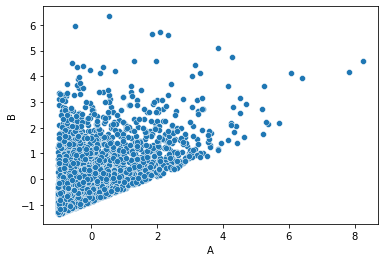

In [9]:
%matplotlib inline
sns.scatterplot(x=train_data["A"], y=train_data["B"])

Initially, it is unclear what the causal relationship between A and B is.

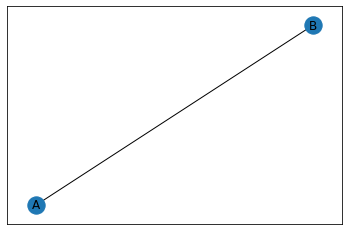

In [10]:
df = pd.DataFrame({'from': ['A'], 'to': ['B']})
G = nx.from_pandas_edgelist(df, 'from', 'to')
nx.draw_networkx(G, arrows=False, with_labels=True)

In [11]:
model = DECI("mymodel", dataset.variables, "mysavedir", device, **model_config) #change cuda to cpu if GPU is not available

In [12]:
model.run_train(dataset, run_context.metrics_logger, training_params)

/home/npawlowski/code/causica_main/open_source/causica/preprocessing/data_processor.py:400: UserWarning: Data too low for continous variables [0 1]
  warnings.warn(
/home/npawlowski/code/causica_main/open_source/causica/preprocessing/data_processor.py:405: UserWarning: Data too high for continous variables [1]
  warnings.warn(
/home/npawlowski/code/causica_main/open_source/causica/utils/helper_functions.py:48: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755934348/work/torch/csrc/utils/tensor_numpy.cpp:178.)
  return tuple(torch.as_tensor(array, dtype=dtype, device=device) for array in arrays)


Auglag Step: 0
LR: 0.05
Inner Step: 500, loss: 2.97, log p(x|A): -2.38, dag: 0.04996343,                 log p(A)_sp: -0.00, log q(A): -0.000, H filled: 0.000, rec: 0.586
Reducing lr to 0.00500
Inner Step: 1000, loss: 2.86, log p(x|A): -2.31, dag: 0.05430808,                 log p(A)_sp: -0.00, log q(A): -0.000, H filled: 0.000, rec: 0.551
Inner Step: 1500, loss: 2.79, log p(x|A): -2.26, dag: 0.06589380,                 log p(A)_sp: -0.00, log q(A): -0.000, H filled: 0.000, rec: 0.535
Inner Step: 2000, loss: 2.75, log p(x|A): -2.22, dag: 0.06897126,                 log p(A)_sp: -0.00, log q(A): -0.000, H filled: 0.000, rec: 0.527
Best model found at innner step 1804, with Loss 2.49
Dag penalty after inner: 0.0689712625
Time taken for this step 24.319637775421143
Unrounded adj matrix:
[[[0.         0.53614908]
  [0.13231814 0.        ]]]
Number of edges in adj matrix (unrounded) 0.6684672236442566, (rounded) 1.0.
Not done inner optimization.
Dag penalty: 0.068971262454987
Rho: 0.00, alp

2022-07-06 15:02:00.124771: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Causal discovery results

In [13]:
graph = model.networkx_graph()
print(graph.edges)

[(0, 1)]


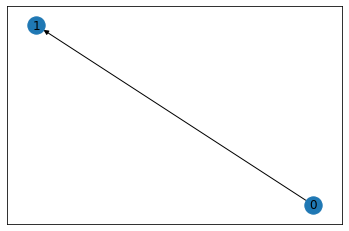

In [14]:
nx.draw_networkx(graph, arrows=True, with_labels=True)

We can compare this with the true graph:

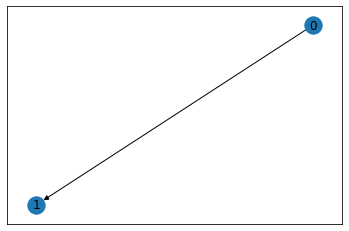

In [15]:
plot_true_graph(dataset)

## Causal inference results

DECI has also fitted an SCM that captures the functional relationship and error distribution of this dataset.

We can estimate ATE and compare it to the ATE estimate from ground truth interventional data. Here we will compute E[B|do(A=1)] - E[B|do(A=-1)].

In [16]:
import numpy as np

intervention_idxs = np.array([0])
outcome_idx = 1

### Model-based ATE estimate
do_1 = model.sample(5000, intervention_idxs=intervention_idxs, intervention_values=np.array([1.])).cpu().numpy()
do_minus_1 = model.sample(5000, intervention_idxs=intervention_idxs, intervention_values=np.array([-1.])).cpu().numpy()
ate_estimate = do_1[:, outcome_idx].mean() - do_minus_1[:, outcome_idx].mean()
print("Estimated ATE:", ate_estimate)

Estimated ATE: 0.9137815


In [17]:
### Interventional test data ATE
ate_true = dataset._intervention_data[0].test_data[:, outcome_idx].mean() - dataset._intervention_data[0].reference_data[:, outcome_idx].mean()
print("Interventional ATE:", ate_true)

Interventional ATE: 0.9873394528627396


In [18]:
print("Theoretical ATE is 1.")

Theoretical ATE is 1.


In [23]:
model.cate(
    intervention_idxs=intervention_idxs, intervention_values=np.array([1]),
    reference_values=np.array([-1.]), effect_idxs=np.array([1]))

(array([0.92462771]), array([0.12033765]))

In [36]:
help(model.cate)

Help on method cate in module open_source.causica.models.deci.deci:

cate(intervention_idxs: 'Union[torch.Tensor, np.ndarray]', intervention_values: 'Union[torch.Tensor, np.ndarray]', reference_values: 'Optional[Union[torch.Tensor, np.ndarray]]' = None, effect_idxs: 'Optional[Union[torch.Tensor, np.ndarray]]' = None, conditioning_idxs: 'Optional[Union[torch.Tensor, np.ndarray]]' = None, conditioning_values: 'Optional[Union[torch.Tensor, np.ndarray]]' = None, Nsamples_per_graph: 'int' = 2, Ngraphs: 'Optional[int]' = 1000, most_likely_graph: 'bool' = False) method of open_source.causica.models.deci.deci.DECI instance
    Returns average treatment effect for a given intervention.
    
    Computes and returns the average treatment effect for a given intervention with the option of conditioning on
    additional variables.
    
    Args:
        intervention_idxs: torch.Tensor of shape (input_dim) array containing indices of variables that have been
            intervened.
        interven

In short, we can start from data, do causal discovery and causal inference, yielding treatment effect estimates that actions can be based upon.

## Graph constraints
First, train on a new dataset with no constraints. *Note*: this is a very difficult dataset in which all variables are strongly correlated with one another.

To load the dataset, first ensure that it has been generated under `./data`

In [27]:
simpson_data = load_data("csuite_nonlin_simpson", "./data", 0, dataset_config, model_config, False, run_context.download_dataset)

/home/npawlowski/code/causica_main/open_source/causica/datasets/csv_dataset_loader.py:132: UserWarning: Validation data file not found: ./data/csuite_nonlin_simpson/val.csv.
  warnings.warn(f"Validation data file not found: {val_data_path}.", UserWarning)


Minimum value of variable Column 0 inferred as -3.2742233276367188. This can be changed manually in the dataset's variables.json file
Max value of variable Column 0 inferred as 3.15141224861145. This can be changed manually in the dataset's variables.json file
Variable Column 0 inferred to be a queriable variable. This can be changed manually in the dataset's variables.json file by updating the "query" field.
Variable Column 0 inferred as not an active learning target variable. This can be changed manually in the dataset's variables.json file by updating the "target" field.
Variable Column 0 inferred as an always observed target variable. This can be changed manually in the dataset's variables.json file by updating the "always_observed" field.
Minimum value of variable Column 1 inferred as -1.5287634134292603. This can be changed manually in the dataset's variables.json file
Max value of variable Column 1 inferred as 2.87360954284668. This can be changed manually in the dataset's varia

In [28]:
print(f"New dataset with {simpson_data.variables.num_groups} nodes.")

New dataset with 4 nodes.


The true graph is:


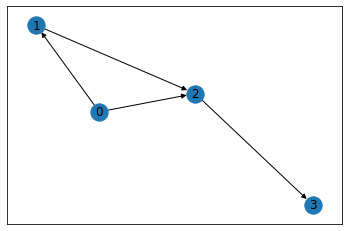

In [29]:
print("The true graph is:")
plot_true_graph(simpson_data)

In [30]:
simpson_df = pd.DataFrame(simpson_data._train_data, columns=simpson_data.variables.group_names)
simpson_df.head()

,Column 0,Column 1,Column 2,Column 3
0,-0.313854,-0.086297,-2.207146,-1.183498
1,0.055711,-0.248166,-0.817248,-0.760595
2,0.111356,-0.385469,-1.035435,-0.775432
3,0.749707,-0.736782,-1.543384,-1.011732
4,0.029076,-0.454397,-1.750655,-1.088691


In [31]:
simpson_model = DECI("mymodel", simpson_data.variables, "mysavedir", device, **model_config)

In [32]:
# You may need more auglag steps / higher rho to make sure you do not get a non-DAG
training_params['max_auglag_inner_epochs'] = 2000
training_params['max_steps_auglag'] = 10

simpson_model.run_train(simpson_data, run_context.metrics_logger, training_params)

/home/npawlowski/code/causica_main/open_source/causica/preprocessing/data_processor.py:400: UserWarning: Data too low for continous variables [0 2 3]
  warnings.warn(
/home/npawlowski/code/causica_main/open_source/causica/preprocessing/data_processor.py:405: UserWarning: Data too high for continous variables [0 2 3]
  warnings.warn(


Auglag Step: 0
LR: 0.05
Inner Step: 500, loss: 4.90, log p(x|A): -4.44, dag: 0.27460284,                 log p(A)_sp: -0.01, log q(A): -0.003, H filled: 0.000, rec: 0.448
Inner Step: 1000, loss: 3.28, log p(x|A): -2.92, dag: 0.68911714,                 log p(A)_sp: -0.01, log q(A): -0.002, H filled: 0.000, rec: 0.355
Inner Step: 1500, loss: 2.63, log p(x|A): -2.30, dag: 0.89266207,                 log p(A)_sp: -0.01, log q(A): -0.001, H filled: 0.000, rec: 0.320
Reducing lr to 0.00500
Inner Step: 2000, loss: 2.30, log p(x|A): -1.99, dag: 0.97393672,                 log p(A)_sp: -0.01, log q(A): -0.001, H filled: 0.000, rec: 0.301
Best model found at innner step 1980, with Loss 1.09
Dag penalty after inner: 0.9739367189
Time taken for this step 43.82605290412903
Unrounded adj matrix:
[[[0.00000000e+00 9.97990668e-01 1.30712986e-04 9.97578442e-01]
  [1.29342079e-05 0.00000000e+00 2.49147415e-05 9.83616710e-01]
  [9.99353290e-01 9.96481597e-01 0.00000000e+00 4.89056110e-04]
  [2.23410130e

Inner Step: 500, loss: 1.43, log p(x|A): -0.82, dag: 1.19935088,                 log p(A)_sp: -0.01, log q(A): -0.000, H filled: 0.000, rec: 0.229
Reducing lr to 0.00000
Inner Step: 1000, loss: 1.42, log p(x|A): -0.82, dag: 1.19072395,                 log p(A)_sp: -0.01, log q(A): -0.000, H filled: 0.000, rec: 0.228
Reducing lr to 0.00000
Inner Step: 1500, loss: 1.42, log p(x|A): -0.81, dag: 1.19267034,                 log p(A)_sp: -0.01, log q(A): -0.000, H filled: 0.000, rec: 0.228
Reducing lr to 0.00000
Exiting at innner step 1556.
Best model found at innner step 56, with Loss 1.34
Dag penalty after inner: 1.1930086037
Time taken for this step 26.97478675842285
Unrounded adj matrix:
[[[0.00000000e+00 9.97965991e-01 1.30653381e-04 9.97949004e-01]
  [1.31130219e-05 0.00000000e+00 2.36630440e-05 9.84566808e-01]
  [9.99354005e-01 9.96659458e-01 0.00000000e+00 4.98175621e-04]
  [1.89882517e-03 1.22287869e-02 9.99456942e-01 0.00000000e+00]]]
Number of edges in adj matrix (unrounded) 5.990

In [33]:
print(simpson_model.networkx_graph().edges)

AssertionError: Generate non DAG graph

If we are not happy with this DAG, we could add some constraints.

Constraints are encoded using an adjacency matrix where:
 - 0 indicates that there is no directed edge i → j,
 - 1 indicates that there has to be a directed edge i → j,
 - nan indicates that the directed edge i → j is learnable.
 
The following function converts from `tabu_` format into this matrix format, for use with DECI.

In [ ]:
def make_constraint_matrix(variables, tabu_child_nodes=None,  tabu_parent_nodes=None, tabu_edges=None):
    """
    Makes a DECI constraint matrix from GCastle constraint format.

    Arguments:
        tabu_child_nodes: Optional[List[str]]
            nodes that cannot be children of any other nodes (root nodes)
        tabu_parent_nodes: Optional[List[str]]
            edges that cannot be the parent of any other node (leaf nodes)
        tabu_edge: Optional[List[Tuple[str, str]]]
            edges that cannot exist
    """

    constraint = np.full((variables.num_groups, variables.num_groups), np.nan)
    name_to_idx = {name: i for (i, name) in enumerate(variables.group_names)}
    if tabu_child_nodes is not None:
        for node in tabu_child_nodes:
            idx = name_to_idx[node]
            constraint[:, idx] = 0.0
    if tabu_parent_nodes is not None:
        for node in tabu_parent_nodes:
            idx = name_to_idx[node]
            constraint[idx, :] = 0.0
    if tabu_edges is not None:
        for source, sink in tabu_edges:
            source_idx, sink_idx = name_to_idx[source], name_to_idx[sink]
            constraint[source_idx, sink_idx] = 0.0
    return constraint.astype(np.float32)

### Adding constraint that a node is not a child
Let's suppose that 'Column 0' is not a child of anything (it's a root node).

In [ ]:
training_params['max_auglag_inner_epochs'] = 1000
training_params['max_steps_auglag'] = 5

In [ ]:
constraint = make_constraint_matrix(simpson_data.variables, tabu_child_nodes=['Column 0'])

In [ ]:
simpson_model = DECI("mymodel", simpson_data.variables, "mysavedir", device, **model_config)
simpson_model.set_graph_constraint(constraint)

In [ ]:
simpson_model.run_train(simpson_data, run_context.metrics_logger, training_params)

In [ ]:
print(simpson_model.networkx_graph().edges)

### Adding constraint that a node is not a parent
Suppose we also want to specify that 'Column 3' is not a parent of anything (it's a leaf node).

In [ ]:
constraint = make_constraint_matrix(
    simpson_data.variables, tabu_child_nodes=['Column 0'], tabu_parent_nodes=['Column 3']
)
simpson_model = DECI("mymodel", simpson_data.variables, "mysavedir", device, **model_config)
simpson_model.set_graph_constraint(constraint)
simpson_model.run_train(simpson_data, run_context.metrics_logger, training_params)

In [ ]:
print(simpson_model.networkx_graph().edges)

### Adding constraint that an edge doesn't exist
Suppose we also want to specify that there is no edge Column 1 to Column 3.

In [ ]:
constraint = make_constraint_matrix(
    simpson_data.variables, tabu_child_nodes=['Column 0'], tabu_parent_nodes=['Column 3'], 
    tabu_edges=[('Column 1', 'Column 3')]
)
simpson_model = DECI("mymodel", simpson_data.variables, "mysavedir", device, **model_config)
simpson_model.set_graph_constraint(constraint)
simpson_model.run_train(simpson_data, run_context.metrics_logger, training_params)

In [ ]:
print(simpson_model.networkx_graph().edges)

### Adding a positive constraint
It's also possible with DECI to force an edge to exist. For example, suppose we decide to enforce the existence of the egde from Column 1 to Column 3.

In [ ]:
constraint[0, 2] = 1.0
simpson_model = DECI("mymodel", simpson_data.variables, "mysavedir", device, **model_config)
simpson_model.set_graph_constraint(constraint)
simpson_model.run_train(simpson_data, run_context.metrics_logger, training_params)

In [ ]:
print(simpson_model.networkx_graph().edges)

In [ ]:
print("The correct graph is ", [(0, 1), (0, 2), (1, 2), (2, 3)])

## A larger graph example

In [ ]:
large_data = load_data("csuite_large_backdoor", "./data", 0, dataset_config, model_config, False, run_context.download_dataset)

In [ ]:
[train_row, train_col] = np.shape(large_data._train_data)

In [ ]:
large_train_data = pd.DataFrame(large_data._train_data, columns=[f"X{i}" for i in range(9)])

In [ ]:
large_train_data.head()

In [ ]:
if train_col < 15:
    sns.pairplot(large_train_data)

In [ ]:
large_model = DECI("mymodel", large_data.variables, "mysavedir", device, **model_config)

In [ ]:
training_params['max_steps_auglag'] = 15
training_params['max_auglag_inner_epochs'] = 3000
large_model.run_train(large_data, run_context.metrics_logger, training_params)

In [ ]:
large_graph = large_model.networkx_graph()

In [ ]:
nx.draw_networkx(large_graph, arrows=True, with_labels=True)

In [ ]:
print("The true graph is:")
plot_true_graph(large_data)

In [ ]:
import numpy as np

### Model-based ATE estimate
do_1 = large_model.sample(5000, intervention_idxs=np.array([7]), intervention_values=np.array([2.])).cpu().numpy()
do_minus_1 = large_model.sample(5000, intervention_idxs=np.array([7]), intervention_values=np.array([0.])).cpu().numpy()
ate_estimate = do_1[:, 8].mean() - do_minus_1[:, 8].mean()
print("Estimated ATE:", ate_estimate)

In [ ]:
### Interventional test data ATE
ate_true = large_data._intervention_data[0].test_data[:, 8].mean() - large_data._intervention_data[0].reference_data[:, 8].mean()
print("Interventional ATE:", ate_true)

## Imputation results

DECI also learns an imputation network that can be used to fill in missing data.

In [ ]:
def make_missing(data):
    missing_data = data.copy()
    mask = np.full(missing_data.shape, fill_value=True, dtype=bool)
    n_rows, n_cols = data.shape
    for row in range(n_rows):
        i = np.random.choice(list(range(n_cols)))
        missing_data[row, i] = 0.
        mask[row, i] = False
    return missing_data, mask

In [ ]:
data_with_missingness, mask = make_missing(dataset._train_data)

In [ ]:
imputed = model.impute(data_with_missingness, mask)

In [ ]:
ax = sns.scatterplot(x=dataset._train_data[~mask], y=imputed[~mask])
ax.set(xlabel="True value", ylabel="Imputed value")

## Analysing the DECI model

DECI gives us a simulator of the observational distribution.

In [ ]:
simulation = pd.DataFrame(model.sample(5000).cpu().numpy(), columns=["A", "B"])

In [ ]:
sns.scatterplot(train_data["A"], train_data["B"])

In [ ]:
sns.scatterplot(simulation["A"], simulation["B"])

The DECI model also allows us to simulate from interventional distributions.

In [ ]:
simulation_intervention = pd.DataFrame(
    model.sample(5000, intervention_idxs=np.array([0]), intervention_values=np.array([4.])).cpu().numpy(), 
    columns=["A", "B"]
)

In [ ]:
simulation_intervention.min()

Intervening on A causes a change in the values of B.

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
sns.kdeplot(simulation_intervention["B"], ax=ax1)
sns.kdeplot(train_data["B"].astype(np.float32), ax=ax2, color='r')

Intervening on B does not cause a change for A.

In [ ]:
simulation_intervention2 = pd.DataFrame(
    model.sample(5000, intervention_idxs=np.array([1]), intervention_values=np.array([1.])).cpu().numpy(), 
    columns=["A", "B"]
)

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
sns.kdeplot(simulation_intervention2["A"], ax=ax1)
sns.kdeplot(train_data["A"].astype(np.float32), ax=ax2, color='r')